Intro to Scalable Computing with Dask in Python - 2

https://www.youtube.com/watch?v=GEdhmCjBBbQ

Data .csv files downloaded from 
https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg2DTracerFieldsSeasonalV17-02.html

as 2, 1-year files

In [2]:
import os
import pandas as pd
home = '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/'
df = pd.read_csv(
    os.path.join(home,'data','ubcSSg2DTracerFieldsSeasonalV17-02_7ab5_3384_00a6.csv'),
    skiprows=[1],
)
df.head() # shows first 5-lines of .csv file

,time,gridY,gridX,salinity,temperature
0,2015-01-15T00:00:00Z,0,0,9.969210e+36,9.969210e+36
1,2015-01-15T00:00:00Z,0,1,9.969210e+36,9.969210e+36
2,2015-01-15T00:00:00Z,0,2,9.969210e+36,9.969210e+36
3,2015-01-15T00:00:00Z,0,3,9.969210e+36,9.969210e+36
4,2015-01-15T00:00:00Z,0,4,9.969210e+36,9.969210e+36


In [21]:
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.csv'
# use thousands = ',' to import numbers as numbers rather than strings
df = pd.read_csv(
    os.path.join(file_dir, file_name), 
    thousands=','
)
df.head() # shows first 5-lines of .csv file

,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,IsRegulatedReceiverFlag,Location,...,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume
0,173454,Maxum - Harbor Island Terminal,12/27/17 11:25,115,1/1/18 6:15,1.0,Maxum (Rainer Petroleum),VICTORIA CLIPPER IV,Y,SEATTLE MAXUM PETROLEUM (EX RAINIER),...,2500,Fueling,NaN,NaN,Paul Lusk,206-613-1442,Facility,PASSENGER SHIP,NaN,10908976886
1,173466,Seaport Midstream Partners LLC,12/27/17 17:50,134,1/2/18 7:00,4.0,TLP Management Services LLC (TMS),GLOBAL PILOT,Y,SEATTLE HARBOR ISLAND PIER 11 (EX-BP),...,546000,Cargo,Y,Y,Sammy Makalena,2066234635 x28,Facility,TANK BARGE,NaN,10908976886
2,173482,PHILLIPS 66 - FERNDALE REFINERY,12/28/17 9:34,91,1/1/18 4:30,12.0,POLAR RESOLUTION,Phillips 66 Ferndale Refinery,Y,FERNDALE PHILLIPS 66,...,12390000,Cargo,Y,Y,Michael J Cherochak,360 384 7822,TANK SHIP,Facility,NaN,10908976886
3,173484,PHILLIPS 66 - FERNDALE REFINERY,12/28/17 9:44,118,1/2/18 7:00,8.0,Phillips 66 Ferndale Refinery,NATHAN SCHMIDT,Y,FERNDALE PHILLIPS 66,...,1176000,Cargo,Y,Y,Michael J Cherochak,360 384 7822,Facility,TANK BARGE,NaN,10908976886
4,173489,BP CHERRY POINT REFINERY,12/28/17 11:03,117,1/2/18 8:00,15.0,SKS SEGURA,BP Cherry Point Refinery,Y,CHERRY POINT BP,...,8820000,Cargo,Y,Y,Justin McCartney,360-371-1321,TANK SHIP,Facility,NaN,10908976886


In [4]:
len(df)

14710

In [5]:
df.dtypes

AntID                          int64
Company                       object
EntryDateTime                 object
HrsBetweenEnryAndTransfer      int64
StartDateTime                 object
Duration                     float64
Deliverer                     object
Receiver                      object
IsRegulatedReceiverFlag       object
Location                      object
StreetAddress                 object
LatNumber                    float64
LongNumber                   float64
City                          object
Region                        object
Product                       object
TransferQtyInGallon            int64
TransferType                  object
IsPreboomed                   object
IsTransferRateGT500           object
ContactName                   object
ContactPhone                  object
DelivererTypeDescription      object
ReceiverTypeDescription       object
RemarksDescription            object
TotalVolume                    int64
dtype: object

In [6]:
df.Deliverer.unique()  #NOT a good example of where to use unique!

array(['Maxum (Rainer Petroleum)', 'TLP Management Services LLC (TMS)',
       'POLAR RESOLUTION', 'Phillips 66 Ferndale Refinery', 'SKS SEGURA',
       'ITB ISLAND TRADER', 'Shell Puget Sound Refinery',
       'Tidewater Snake River Terminal', 'EXPLORER', 'Pacific Ethanol',
       'Nelson Petroleum', 'Pacific Functional Fluids, LLC',
       'U.S. Oil & Refining', 'PROFESSOR KAREN ANN BROWN',
       'Tesoro Port Angeles Terminal', 'HMS 2000', 'HMS 2604', 'HMS 26-1',
       'DR. BONNIE W. RAMSEY', 'Reisner Distributor, Inc.',
       'GLOBAL PILOT', 'ALASKAN NAVIGATOR', 'ATB BARGE 650-10', 'WARRIOR',
       'Naval FISC Manchester Fuel Depot (Mobile)', 'YON-326',
       'Naval Base Kitsap at Bremerton',
       'Kinder Morgan Liquids Terminal - Harbor Island',
       'Covich Williams Co Inc', 'BETSY ARNTZ',
       'Tidewater Vancouver Terminal', 'Connell Oil Inc',
       'BP Cherry Point Refinery', 'NATHAN SCHMIDT',
       'Alon Asphalt Company (Paramount Petroleum)',
       'Andeavor Anac

In [22]:
# first convert transfer quantity to gallons and then take mean accordign to deliverer
df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float)
meanDelivery = df.groupby('Deliverer').TransferQtyInGallon.mean()

In [23]:
meanDelivery

Deliverer
  USCG MELON        3.500000e+03
 MT PICHINCHA       8.400000e+06
ALASKA VICTORY      3.500000e+03
ALASKAN EXPLORER    2.028053e+07
ALASKAN FRONTIER    1.419034e+07
                        ...     
atlantic sirius     3.280700e+06
global provider     6.056500e+03
global prrovider    5.150000e+03
thiessen oil        2.500000e+04
thiesson oil        2.500000e+03
Name: TransferQtyInGallon, Length: 339, dtype: float64

## The next part brings in information from multiple files, so we first need to create multiple files. I do so here by creating monthly data files

### Question: what is the average per month?

In [83]:
# note: I'm not sure if data is in PST or UTC...but this will serve as an example
df.EntryDateTime = df.EntryDateTime.astype('datetime64[ns, US/Pacific]')
df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float)
df

,Unnamed: 0,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,IsRegulatedReceiverFlag,...,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume
0,10360,183016,Kinder Morgan,2018-09-01 03:49:00-07:00,17,9/1/18 20:00,7.0,NATHAN SCHMIDT,Kinder Morgan Liquids Terminal - Harbor Island,Y,...,546000.0,Cargo,Y,Y,Andrew Holbrook,206-682-4706,TANK BARGE,Facility,submitted by E McKee 9.1.2018,10908976886
1,10361,183017,KIRBY OFFSHORE MARINE LLC,2018-09-01 17:41:00-07:00,74,9/4/18 19:00,1.0,ATB BARGE DBL 185,BP Cherry Point Refinery,Y,...,53760.0,Cargo,NaN,Y,"Chief Mate, Dublin Sea",1-206-409-8861,TANK BARGE,Facility,Discharging tank prep flush material (ex-gas) ...,10908976886
2,10362,183018,"OLYMPIC TUG & BARGE, INC.",2018-09-01 21:04:00-07:00,20,9/2/18 17:00,8.0,WEBB MOFFETT,SeaPort Sound Terminal,Y,...,840000.0,Cargo,Y,Y,Brian Healy,206 793 7069,TANK BARGE,Facility,NaN,10908976886
3,10363,183019,"OLYMPIC TUG & BARGE, INC.",2018-09-01 21:07:00-07:00,10,9/2/18 7:00,5.0,SHAUNA KAY,EMERALD PRINCESS,Y,...,147631.0,Fueling,Y,Y,Brian Healy,206 793 7069,TANK BARGE,PASSENGER SHIP,NaN,10908976886
4,10364,183019,"OLYMPIC TUG & BARGE, INC.",2018-09-01 21:07:00-07:00,10,9/2/18 7:00,5.0,SHAUNA KAY,EMERALD PRINCESS,Y,...,180438.0,Fueling,Y,Y,Brian Healy,206 793 7069,TANK BARGE,PASSENGER SHIP,NaN,10908976886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,11679,184190,Phillips66,2018-09-30 01:26:00-07:00,16,9/30/18 17:00,7.0,PROFESSOR KAREN ANN BROWN,Phillips 66 Tacoma Terminal,Y,...,756000.0,Cargo,NaN,Y,Gary Anderson,253-627-3878,TANK BARGE,Facility,We do not pre-boom diesel transfers while gaso...,10908976886
1320,11680,184191,US Oil Trading LLC,2018-09-30 08:36:00-07:00,23,10/1/18 7:00,4.0,U.S. Oil & Refining,WEDELL FOSS,NaN,...,20000.0,Fueling,Y,Y,Robert B Redd,253-680-3236,Facility,NOT COVERED VESSEL,NaN,10908976886
1321,11681,184192,TESORO PASCO TERMINAL,2018-09-30 15:21:00-07:00,41,10/2/18 8:00,10.0,Tesoro Pasco Terminal,NEW FRONTIER,Y,...,1050000.0,Cargo,NaN,Y,Dan Anderson,509 543-6102,Facility,TANK BARGE,Barge is to be loaded and then pumped back int...,10908976886
1322,11682,184193,"POLAR TANKERS, INC. (PUGET SOUND AGENCY)",2018-09-30 15:29:00-07:00,77,10/3/18 20:30,36.0,POLAR ENDEAVOUR,Shell Puget Sound Refinery,Y,...,25200000.0,Cargo,Y,Y,John K. Wright,281-851-7579,TANK SHIP,Facility,POLAR ENDEAVOUR v.362 - 2 parcels single berthing,10908976886


In [84]:
df_bymonth = {}
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
for month_index in range(12):
    df_bymonth = df[df['EntryDateTime'].dt.month == month_index+1]
    df_bymonth.to_csv(os.path.join(home,'data/DOE',f'DOE_bymonth_{month[month_index]}.csv'))
    del df_bymonth

### Sequential code with for loop to read in multiple files

In [85]:
from glob import glob
filenames = sorted(glob(os.path.join(home,'data/DOE',"*.csv")))
filenames

['/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_apr.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_aug.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_dec.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_feb.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_jan.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_jul.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_jun.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_mar.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_may.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_nov.csv',
 '/Users/rmueller/Projects/MOAD/PythonNotes/dask-references/data/DOE/DOE_bymonth_oct.csv',

In [89]:
%%time
import numpy as np
sums = []
counts = []
for fn in filenames:
    df = pd.read_csv(fn)
    by_origin = df.groupby('Deliverer')
    total = by_origin.TransferQtyInGallon.sum()
    count = by_origin.TransferQtyInGallon.count()
    
    sums.append(total)
    counts.append(count)
    
total_gallons = sum(sums)
total_transfers = sum(counts)
mean = total_gallons / total_transfers
mean

CPU times: user 182 ms, sys: 8.6 ms, total: 191 ms
Wall time: 226 ms


Deliverer
ALASKAN EXPLORER           NaN
ALASKAN LEGEND             NaN
ALASKAN NAVIGATOR          NaN
ALYARMOUK                  NaN
AMERICAN ENDURANCE         NaN
                            ..
Wilcox & Flegel (Mobile)   NaN
YON-322                    NaN
YON-325                    NaN
YON-326                    NaN
Yorkston Oil Company       NaN
Name: TransferQtyInGallon, Length: 101, dtype: float64

#### NOTE: These NaNs shouldn't be here but my go-to nansum isn't doing the trick and I'm moving on :-)

#### Parallelize with dask.delayed

In [91]:
%%time
from dask import delayed

sums = []
counts = []
for fn in filenames:
    # setting a delayed object makes all subsequent delayed as well 
    df = delayed(pd.read_csv(fn))
    by_origin = df.groupby('Deliverer')
    total = by_origin.TransferQtyInGallon.sum()
    count = by_origin.TransferQtyInGallon.count()
    
    sums.append(total)
    counts.append(count)
    
total_gallons = delayed(sum)(sums)
total_transfers = delayed(sum)(counts)
mean = total_gallons / total_transfers
mean.compute()


CPU times: user 367 ms, sys: 132 ms, total: 499 ms
Wall time: 571 ms


Deliverer
ALASKAN EXPLORER           NaN
ALASKAN LEGEND             NaN
ALASKAN NAVIGATOR          NaN
ALYARMOUK                  NaN
AMERICAN ENDURANCE         NaN
                            ..
Wilcox & Flegel (Mobile)   NaN
YON-322                    NaN
YON-325                    NaN
YON-326                    NaN
Yorkston Oil Company       NaN
Name: TransferQtyInGallon, Length: 101, dtype: float64

#### NOTE: Not a great example.  We don't save time here

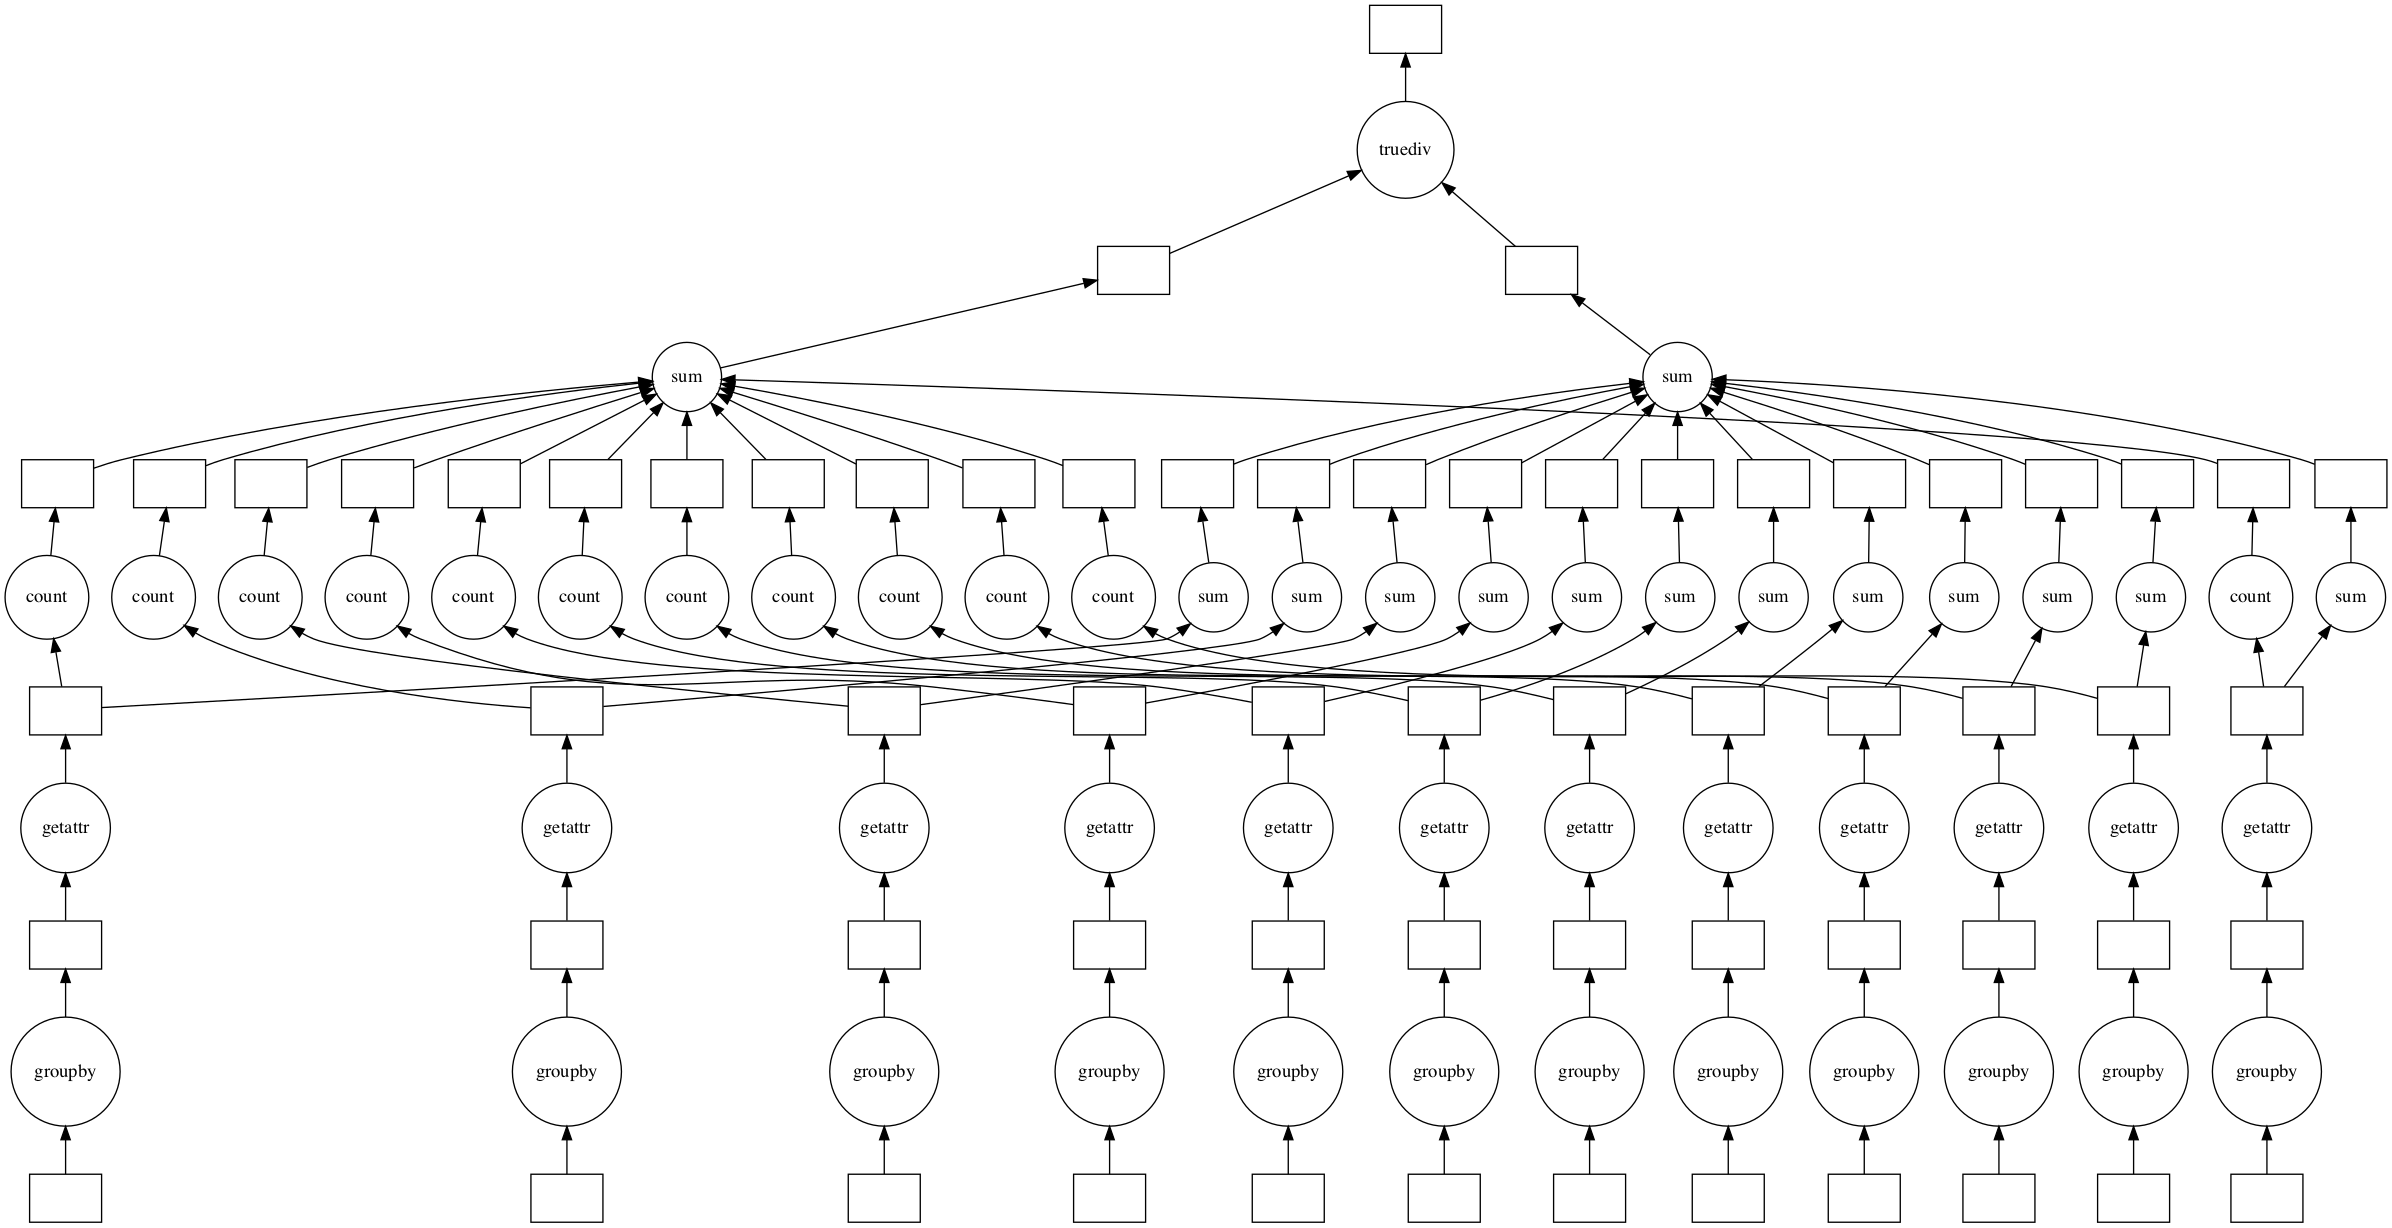

In [92]:
mean.visualize()

### Solution 3: Computation with dask.dataframe
Looks like Pandas dataframe but with lazy evaluation like dask.Delayed()
dask.dataframe.read_csv() can take a string for multiple files

In [94]:
import dask.dataframe as dd
df = dd.read_csv(os.path.join(home,'data/DOE',"*.csv"))
df

,Unnamed: 0,Unnamed: 0.1,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,IsRegulatedReceiverFlag,Location,StreetAddress,LatNumber,LongNumber,City,Region,Product,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume
npartitions=12,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Unlike pandas, dask.dataframe only reads part of data from beginning of file to parse data and column name and datatype is forced for the rest of entries.  Same kinds of queries apply as with pandas.dataframe:

In [95]:
df.dtypes

Unnamed: 0                   object
Unnamed: 0.1                 object
AntID                        object
Company                      object
EntryDateTime                object
HrsBetweenEnryAndTransfer    object
StartDateTime                object
Duration                     object
Deliverer                    object
Receiver                     object
IsRegulatedReceiverFlag      object
Location                     object
StreetAddress                object
LatNumber                    object
LongNumber                   object
City                         object
Region                       object
Product                      object
TransferQtyInGallon          object
TransferType                 object
IsPreboomed                  object
IsTransferRateGT500          object
ContactName                  object
ContactPhone                 object
DelivererTypeDescription     object
ReceiverTypeDescription      object
RemarksDescription           object
TotalVolume                 

In [96]:
df.head()

/Users/rmueller/opt/miniconda3/envs/dask/lib/python3.9/site-packages/dask/dataframe/core.py:6560: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,Unnamed: 0,Unnamed: 0.1,AntID,Company,EntryDateTime,HrsBetweenEnryAndTransfer,StartDateTime,Duration,Deliverer,Receiver,...,TransferQtyInGallon,TransferType,IsPreboomed,IsTransferRateGT500,ContactName,ContactPhone,DelivererTypeDescription,ReceiverTypeDescription,RemarksDescription,TotalVolume


In [99]:
len(df)

1324

### Now calculate average fuel transfers using dask.dataframe

In [103]:
%%time
# using dask.dataframe without loop

import dask.dataframe as dd
df = dd.read_csv(os.path.join(home,'data/DOE',"*.csv"))
# With this particular file, we need to specify the type as numeric
df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float)
# delayed average computation for all files
mean = df.groupby('Deliverer').TransferQtyInGallon.mean()
mean.compute()

CPU times: user 315 ms, sys: 26.6 ms, total: 342 ms
Wall time: 375 ms


Deliverer
ALASKAN EXPLORER            22823430.0
ALASKAN LEGEND              18816546.0
ALASKAN NAVIGATOR           12600000.0
ALYARMOUK                   11130000.0
AMERICAN ENDURANCE           4347000.0
                               ...    
Wilcox & Flegel (Mobile)         540.0
YON-322                        95000.0
YON-325                       567000.0
YON-326                       567000.0
Yorkston Oil Company             852.0
Name: TransferQtyInGallon, Length: 101, dtype: float64

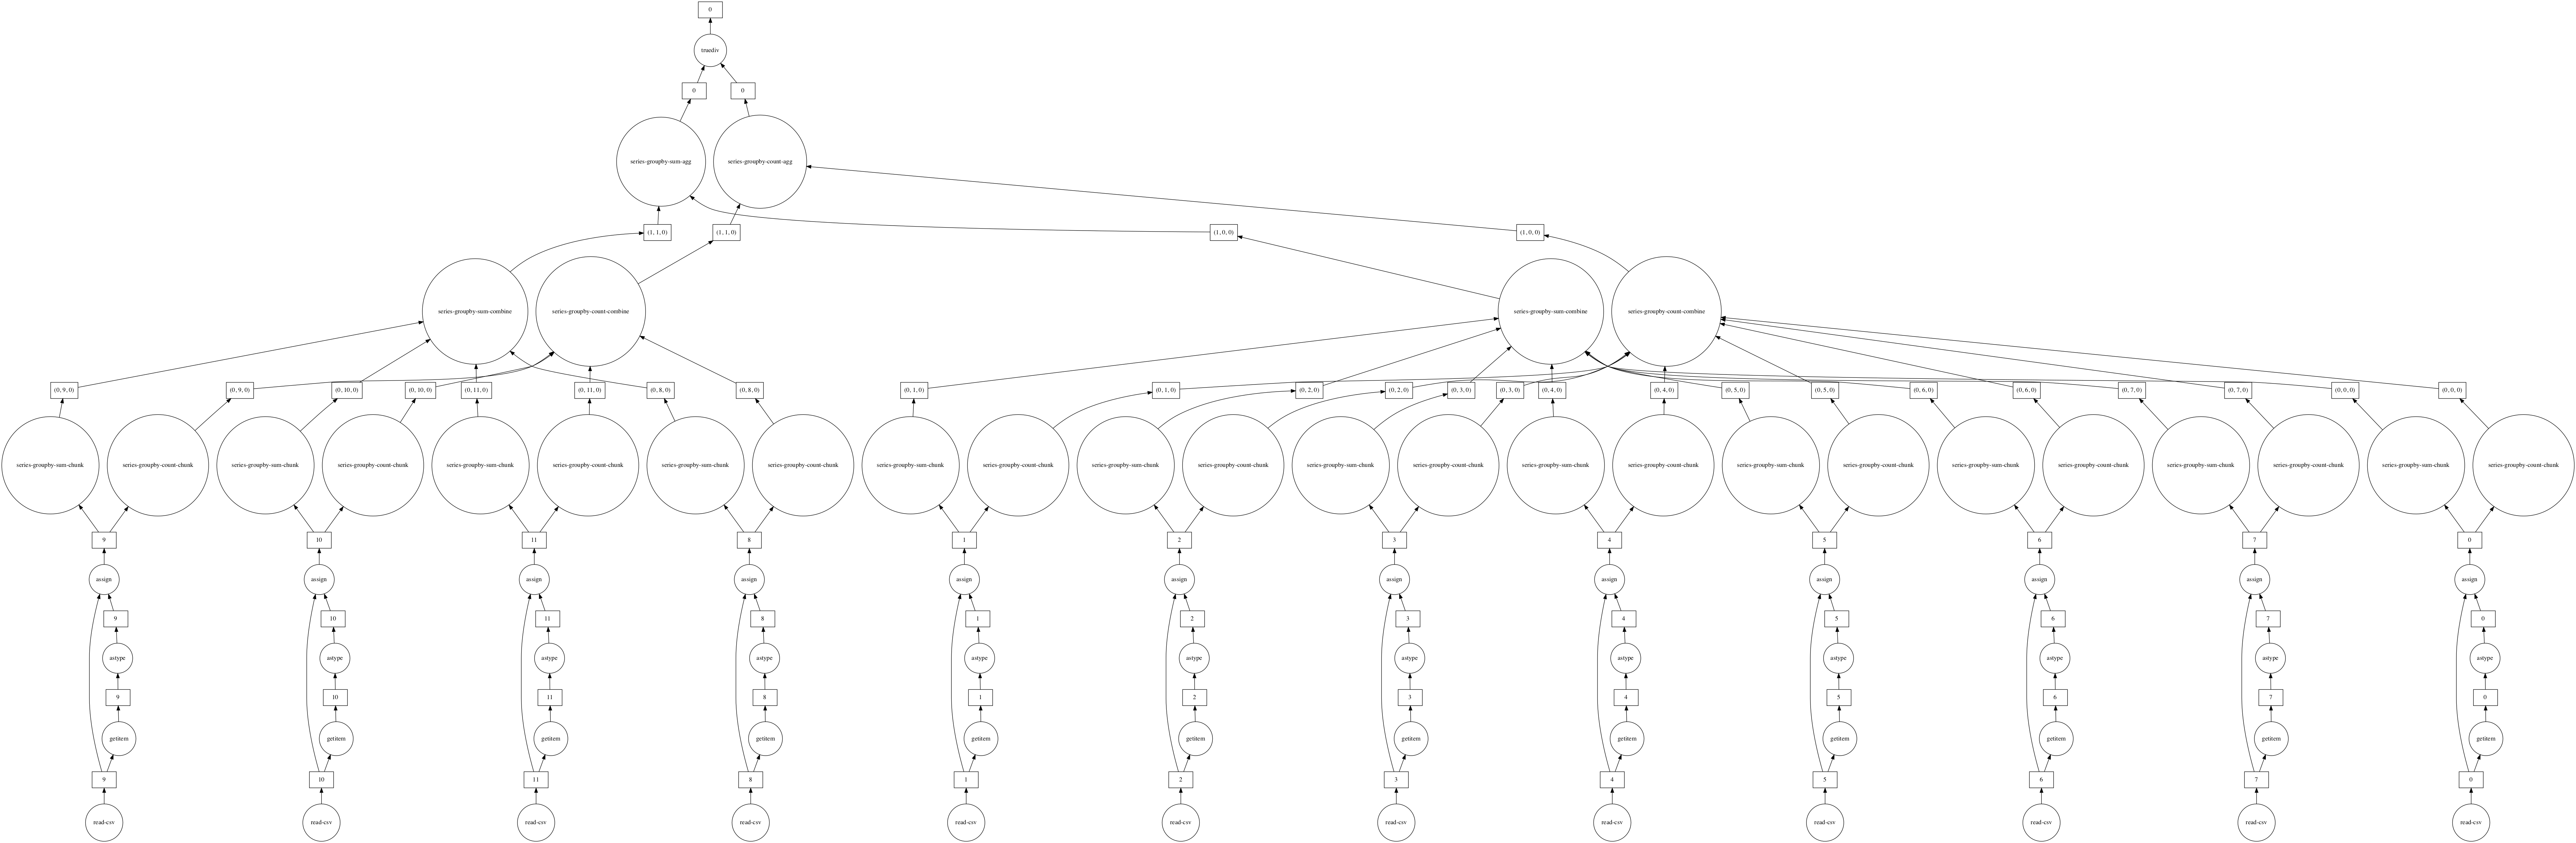

In [104]:
mean.visualize()

In [106]:
# add compute() at end to show result of calculation
df.groupby('Deliverer').TransferQtyInGallon.max().compute()

Deliverer
ALASKAN EXPLORER            22823430.0
ALASKAN LEGEND              18900000.0
ALASKAN NAVIGATOR           12600000.0
ALYARMOUK                   11130000.0
AMERICAN ENDURANCE          12600000.0
                               ...    
Wilcox & Flegel (Mobile)         540.0
YON-322                       130000.0
YON-325                       567000.0
YON-326                       567000.0
Yorkston Oil Company            2500.0
Name: TransferQtyInGallon, Length: 101, dtype: float64

## Take aways:
- Pandas:
    - loop over file
    - then calculate values
- dask.delayed: 
    - still think about loops, intermediate results, then final reduction
- dask.dataframe:
    - reads multiple files at once
    - automatically parallelizes
    - large datasets partitioned into smaller dataframes
